# Understanding Methods of Computing Melting Rates

I need a method of computing the melting rate of the crystal structures which will provide a good estimation of both the melting rate and the error of the melting rate. Importantly I need an algorith able to detect the small melting rates at low temperatures.

In [1]:
import numpy as np
import pandas
import altair as alt
import scipy.stats

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Load Data

The data on the melting rates has been precalculated and saved to a file. The data stored is the simulation conditions along with the values
- fraction: The fraction of the simulation cell which is crystalline in nature
- surface_area: The perimeter (the 2D equivalent of surface area) of the crystalline cluster
- volume: The area (2D equivalent of area) of the crystalline cluster
- time: The timestep at which these values apply.

Only the data from the low temperature melting is used in this analysis since at the time of writing the dataset is better and it is easier to only deal with a single set of pressures. I am also limiting the analysis to only the p2 crystal.

By resampling the dataset to times of 1ms, the 

In [2]:
# Read file with melting data
norm_df = pandas.read_hdf('../data/analysis/melting.h5', 'fractions', mode='r')
norm_df = norm_df.query('pressure == "1.00" and temperature < 0.8')
norm_df = norm_df.query('volume > 2000')
norm_df = norm_df.query('time > 0.')
# norm_df = norm_df.query('crystal != "p2gg"')
norm_df = norm_df.query('crystal == "p2"')
group_bys = ['crystal', 'temperature', 'pressure']
time_df = norm_df.copy()
time_df.index = pandas.TimedeltaIndex(norm_df.time)
# time_df = time_df.groupby(group_bys).resample('1ms').mean().reset_index(drop=True)
time_df.dropna(inplace=True)

## Volume Data

I have plotted the volume of the crystal as a fucntion of time below. The important point to note is the high levels of noise in the data, which is a combination the thermal fluctuations and the inacuracy of the algorithm I am using for classification.

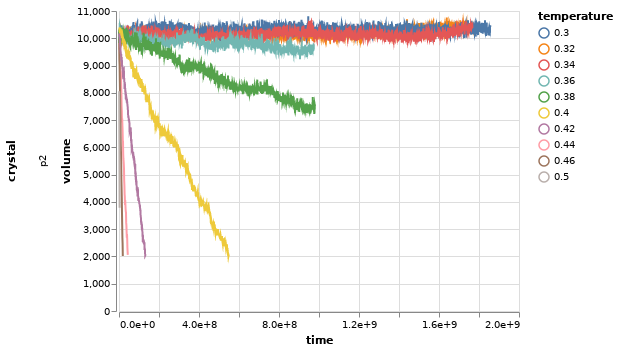

In [3]:
chart = alt.Chart(time_df).mark_line().encode(
    x=alt.X('time:Q', axis=alt.Axis(format='e')),
    color='temperature:N',
    row='crystal:N',
    y='volume:Q',
)
chart

In [5]:
# chart.save('../figures/melting_Trimer-P1.00-p2.png')

## Calculating $\Delta V/ \Delta t$

The quantity we are interested in is rate of melting for a given surface area,
$$
\tau_M = -\frac{1}{A} \frac{\Delta V}{\Delta t}
$$
since our expectation is that $\tau_M$ is a constant value, fitting a straight line to $\Delta V/\Delta t$ will end up giving a value of $\tau_M$ which is dependent on the surface area.

This documents my attempts at calculating this value with a small error.

### Averaging Instantaneous gradient

This is calculating the instantaneous gradient $\frac{1}{A(t)} \frac{V(t+\Delta t) - V(t)}{\Delta t}$ and averaging over all $t$. The errors being calculated as the standard deviation. The gradient is computed using the`np.gradient` function which documents the solver [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html#numpy.gradient).

In [6]:
def instantaneous_gradient(df):
    if len(df.volume > 2):
        return np.gradient(df.volume, df.time) / df.surface_area
    elif len(df == 2):
        return (1/df.surface_area[0]) * (df.volume[1] - df.volume[0])/(df.time[1] - df.time[0])
    else:
        return 0
        

gradient_mean = time_df.groupby(group_bys).apply(
    lambda x: np.nanmean(instantaneous_gradient(x))
)
gradient_error = time_df.groupby(group_bys).apply(
    lambda x: np.nanstd(instantaneous_gradient(x))
)

gradient1 = pandas.DataFrame({'mean': gradient_mean, 'error': gradient_error})
gradient1.reset_index(inplace=True)

Plotting the melting rate with the calculated errors as a function of temperature.

/home/malcolm/.miniconda/envs/crystal/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


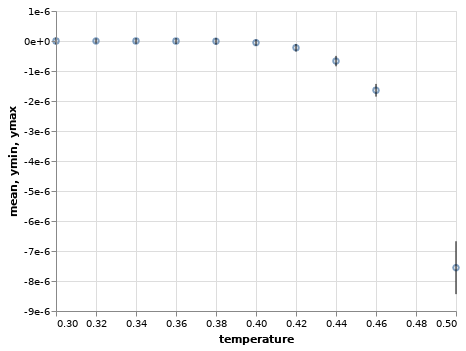

In [7]:
chart = alt.Chart(gradient1).mark_point().transform_calculate(
    ymin="datum.mean-datum.error/2",
    ymax="datum.mean+datum.error/2"
).encode(
    alt.X('temperature:Q', scale=alt.Scale(zero=False))
)

disp_chart = (
    chart.encode(alt.Y('mean', axis=alt.Axis(format='e'))) + 
    chart.mark_rule().encode(y='ymin:Q', y2='ymax:Q')
)
disp_chart

In [8]:
# disp_chart.save("../figures/melting_rates_Trimer-P1.00-p2.png")

This figure corresponds to the values in the table below, which also includes the fractional error. A value of the fractional error > 1 would indicate that the value is not distinguishable from 0.

In [9]:
gradient1['frac_error'] = np.abs(gradient1['error'] / gradient1['mean'])
gradient1

,crystal,temperature,pressure,mean,error,frac_error
0,p2,0.30,1.0,3.183932e-10,2.311358e-07,725.944425
1,p2,0.32,1.0,4.879139e-10,1.700305e-07,348.484564
2,p2,0.34,1.0,3.953011e-10,1.875498e-07,474.447920
3,p2,0.36,1.0,-9.810415e-10,1.956090e-07,199.389152
4,p2,0.38,1.0,-8.283162e-09,2.214134e-07,26.730544
5,p2,0.40,1.0,-5.530639e-08,2.096505e-07,3.790710
6,p2,0.42,1.0,-2.243827e-07,2.532320e-07,1.128572
7,p2,0.44,1.0,-6.699130e-07,3.474372e-07,0.518630
8,p2,0.46,1.0,-1.642584e-06,4.230820e-07,0.257571
9,p2,0.50,1.0,-7.556482e-06,1.763823e-06,0.233418


#### Standard Error of the Mean

With the errors using the standard deviation being many orders of magnitude larger than some of the values I am trying to calculate, a more appropriate measure of the error is using the Standard Error of the Mean (SEM) which takes into account the number of samples in the calculation of the error. Since I have a large number of samples this should be a much more appropriate metric.

In [10]:
gradient_mean = time_df.groupby(group_bys).apply(
    lambda x: np.nanmean(instantaneous_gradient(x))
)
gradient_error = time_df.groupby(group_bys).apply(
    lambda x: scipy.stats.sem(instantaneous_gradient(x), nan_policy='omit')
)

gradient2 = pandas.DataFrame({'mean': gradient_mean, 'error': gradient_error})
gradient2.reset_index(inplace=True)

Plotting the data shows the errors significatnly reduced over the standard deviation error calculation although while the errors are small the values are also really small.

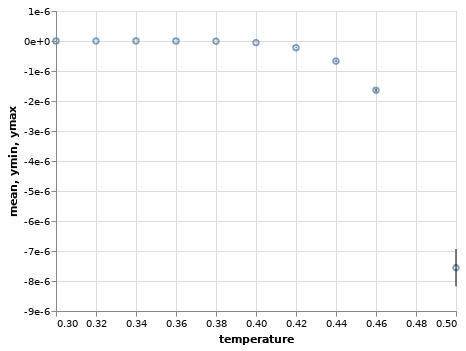

In [11]:
chart = alt.Chart(gradient2).mark_point().transform_calculate(
    ymin="datum.mean-datum.error/2",
    ymax="datum.mean+datum.error/2"
).encode(
    alt.X('temperature:Q', scale=alt.Scale(zero=False))
)

disp_chart = (
    chart.encode(y=alt.Y('mean', axis=alt.Axis(format='e'))) + 
    chart.mark_rule().encode(y='ymin:Q', y2='ymax:Q')
)
disp_chart

In [12]:
gradient2['frac_error'] = np.abs(gradient2['error'] / gradient2['mean'])
gradient2

,crystal,temperature,pressure,mean,error,frac_error
0,p2,0.30,1.0,3.183932e-10,5.366550e-09,16.855103
1,p2,0.32,1.0,4.879139e-10,4.038056e-09,8.276166
2,p2,0.34,1.0,3.953011e-10,4.460417e-09,11.283593
3,p2,0.36,1.0,-9.810415e-10,6.267718e-09,6.388841
4,p2,0.38,1.0,-8.283162e-09,7.076404e-09,0.854312
5,p2,0.40,1.0,-5.530639e-08,8.947665e-09,0.161784
6,p2,0.42,1.0,-2.243827e-07,2.212498e-08,0.098604
7,p2,0.44,1.0,-6.699130e-07,5.298367e-08,0.079090
8,p2,0.46,1.0,-1.642584e-06,9.972139e-08,0.060710
9,p2,0.50,1.0,-7.556482e-06,1.247211e-06,0.165052


The SEM does provide a significantly smaller estimate of the error, although it is still larger than the smallest values. The value for 0.38 should be clearly melting, however in this case the error is still half the value and so barely an indication of melting.

## What error is Acceptible

Making the assumption that the perimeter doesn't change over the course of the simulation I can fit a straight line to the volume to get an estimate of the melting rate. This is the approach which will have the lowest error in the slope of the line, although there is a much larger error in assumption the surface area is constant for all temperatures above 0.38. The main idea of this approach is to give an indication of whether the errors are a result of the data or the methods I am using.

There are two separate values I am using for the surface area. The initial surface area, with results in gradient4 and the mean surface area with the results in gradient5. The use of the mean value is to better match the results from the other derivative methods.

In [13]:
def gradient_regression_first(df):
    """Calculate the gradient using linear regression.
    
    The y value of the gradient is of each volume divided by the initial 
    surface area.
    
    """
    df = df.dropna()
    slope, _, _, _, std_err = scipy.stats.linregress(
        x=df.time, 
        y=df.volume / df.surface_area[0]
    )
    return slope, std_err

gradient_mean = time_df.groupby(group_bys).apply(
    lambda x: gradient_regression_first(x)[0]
)
gradient_error = time_df.groupby(group_bys).apply(
    lambda x: gradient_regression_first(x)[1]
)

gradient4 = pandas.DataFrame({'mean': gradient_mean, 'error': gradient_error})
gradient4.reset_index(inplace=True)

In [14]:
def gradient_regression_mean(df):
    """Calculate the gradient using linear regression.
    
    The y value of the gradient is of eah volume divided by the mean
    of the surface area over the course of the simulation. This is an 
    adjustment to bring the accuracy of the resulting slope closer to
    that calculated by other methods.
    
    """
    df = df.dropna()
    slope, _, _, _, std_err = scipy.stats.linregress(df.time, df.volume/df.surface_area.mean())
    return slope, std_err

gradient_mean = time_df.groupby(group_bys).apply(
    lambda x: gradient_regression_mean(x)[0]
)
gradient_error = time_df.groupby(group_bys).apply(
    lambda x: gradient_regression_mean(x)[1]
)

gradient5 = pandas.DataFrame({'mean': gradient_mean, 'error': gradient_error})
gradient5.reset_index(inplace=True)

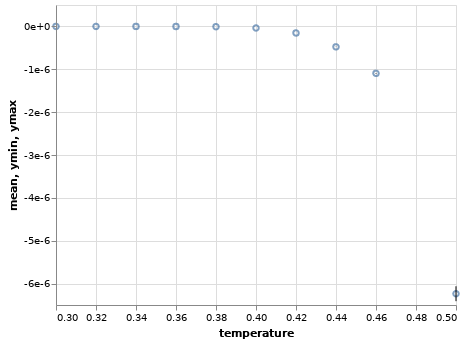

In [15]:
chart = alt.Chart(gradient4).mark_point().transform_calculate(
    ymin="datum.mean-datum.error/2",
    ymax="datum.mean+datum.error/2"
).encode(
    alt.X('temperature:Q', scale=alt.Scale(zero=False))
)

(
    chart.encode(y=alt.Y('mean', axis=alt.Axis(format='e'))) + 
    chart.mark_rule().encode(y='ymin:Q', y2='ymax:Q')
)

In [16]:
gradient4['frac_error'] = np.abs(gradient4['error'] / gradient4['mean'])
gradient4

,crystal,temperature,pressure,mean,error,frac_error
0,p2,0.30,1.0,4.789915e-11,1.483844e-11,0.309785
1,p2,0.32,1.0,3.054511e-10,1.521773e-11,0.049821
2,p2,0.34,1.0,7.722801e-11,1.445434e-11,0.187165
3,p2,0.36,1.0,-1.171812e-09,3.876414e-11,0.033081
4,p2,0.38,1.0,-6.966158e-09,4.491310e-11,0.006447
5,p2,0.40,1.0,-3.590905e-08,1.289772e-10,0.003592
6,p2,0.42,1.0,-1.530221e-07,6.534855e-10,0.004271
7,p2,0.44,1.0,-4.773211e-07,7.065484e-09,0.014802
8,p2,0.46,1.0,-1.094180e-06,1.477123e-08,0.013500
9,p2,0.50,1.0,-6.236638e-06,3.481678e-07,0.055826


The errors in this approximation of the values is significantly smaller than any of the other methods. Additionally the errors and the values are more consistent throughout the range of temperatures, with no sudden jumps between values. I wouldn't look too much into the volume slightly increasing at the lower temperatures, with the values indicating an enroachment of the liquid phase by 0.7 units of distance over the timescale of the simulation; just over half the width of a molecule.

## Overall Assessment

Taking all the calcualted values of the melting rates and making a comparison of the different techniques. This is to see how consistent the different methods are at calculating these derivatives.

In [17]:
gradient1['exp'] = 1
gradient2['exp'] = 2
gradient4['exp'] = 4
gradient5['exp'] = 5
gradients_all = pandas.concat([gradient2, gradient4, gradient5], axis=0, sort=True)

Plotting all the different approaches (labelled exp), on the same figure it is simple to compare them. The first approach to calculating the error is obviously wrong so I have excluded the results for clarity.

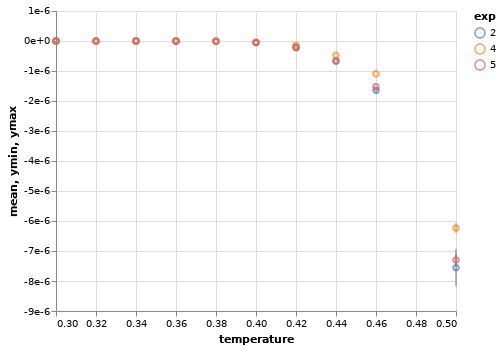

In [18]:
chart = alt.Chart(gradients_all).mark_point().transform_calculate(
    ymin="datum.mean-datum.error/2",
    ymax="datum.mean+datum.error/2"
).encode(
    alt.X('temperature:Q', scale=alt.Scale(zero=False)),
    color='exp:N',
)

(
    chart.encode(y=alt.Y('mean', axis=alt.Axis(format='e'))) + 
    chart.mark_rule().encode(y='ymin:Q', y2='ymax:Q')
)

The second and third approach give very similar results, even when comparing the results in a table. For the values in the fourth approach can be brought much closer to the other values taking the mean of the perimeter rather than the initial value. Although the fifth appraoch still falls down at above T=0.42.

To be able to more easily compare the values a log plot would make more sense, however since some of the values are negative this is not possible without some manipulation of the data. The figure below shows the data from each approach where the lowest estimated range is above 5e-10. Additionally all the values are now the absolute magnitude to allow for the log plot.

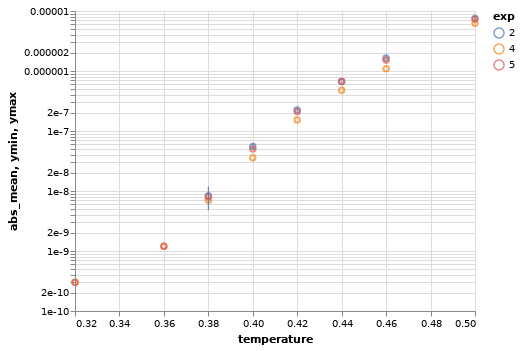

In [19]:
chart = alt.Chart(gradients_all).mark_point().transform_calculate(
    abs_mean='abs(datum.mean)',
    ymin="datum.abs_mean-datum.error/2",
    ymax="datum.abs_mean+datum.error/2"
).transform_filter(
    "datum.ymin > 1e-10"
).encode(
    alt.X('temperature:Q', scale=alt.Scale(zero=False)),
    color='exp:N',
)

(
    chart.encode(y=alt.Y('abs_mean:Q', scale=alt.Scale(type='log'))) +
    chart.encode(y='ymin:Q', y2='ymax:Q').mark_rule()
)